In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [11]:
lengths = np.array([195, 185])

In [12]:
# lets create a grid of our two parameters
mu = np.linspace(150, 250)
sigma = np.linspace(0, 15)[::-1]

mm, ss = np.meshgrid(mu, sigma)  # just broadcasted parameters

/opt/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1662: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


Text(0, 0.5, '$\\sigma$')

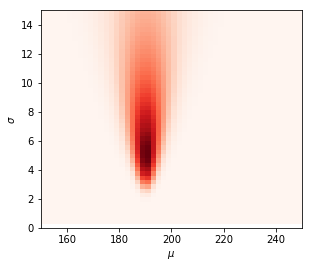

In [13]:
likelihood = stats.norm(mm, ss).pdf(lengths[0]) * stats.norm(mm, ss).pdf(lengths[1])
aspect = mm.max() / ss.max() / 3
extent = [mm.min(), mm.max(), ss.min(), ss.max()]
# extent = left right bottom top
plt.imshow(likelihood, cmap='Reds', aspect=aspect, extent=extent) 
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

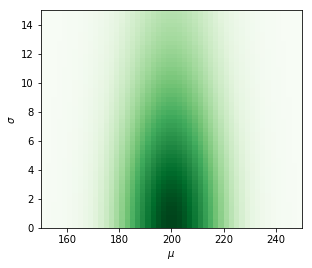

In [14]:
prior = stats.norm(200, 15).pdf(mm) * stats.cauchy(0, 10).pdf(ss)

plt.imshow(prior, cmap='Greens', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

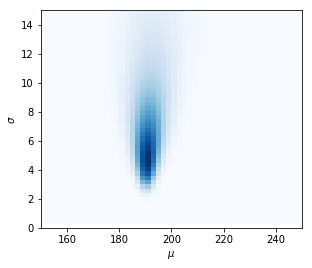

In [15]:
unnormalized_posterior = prior * likelihood
posterior = unnormalized_posterior / np.nan_to_num(unnormalized_posterior).sum()
plt.imshow(posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

Text(0, 0.5, '$\\sigma$')

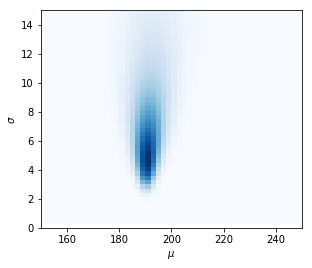

In [7]:
plt.imshow(unnormalized_posterior, cmap='Blues', aspect=aspect, extent=extent)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')

In [57]:
import pymc3 as pm

In [58]:
with pm.Model():
    # priors
    mu = pm.Normal('mu', mu=200, sd=15)
    sigma = pm.HalfCauchy('sigma', 10)
    
    # likelihood
    observed = pm.Normal('observed', mu=mu, sd=sigma, observed=lengths)
    # sample
    trace = pm.sample(draws=10000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 10500/10500 [00:07<00:00, 1402.54it/s]
The acceptance probability does not match the target. It is 0.8838815681167924, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


/opt/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


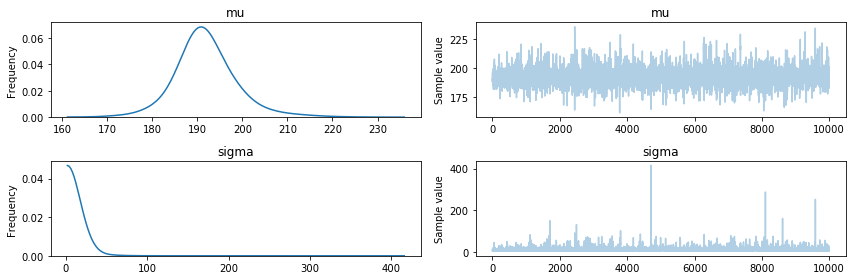

In [59]:
pm.traceplot(trace);

(0, 15.0)

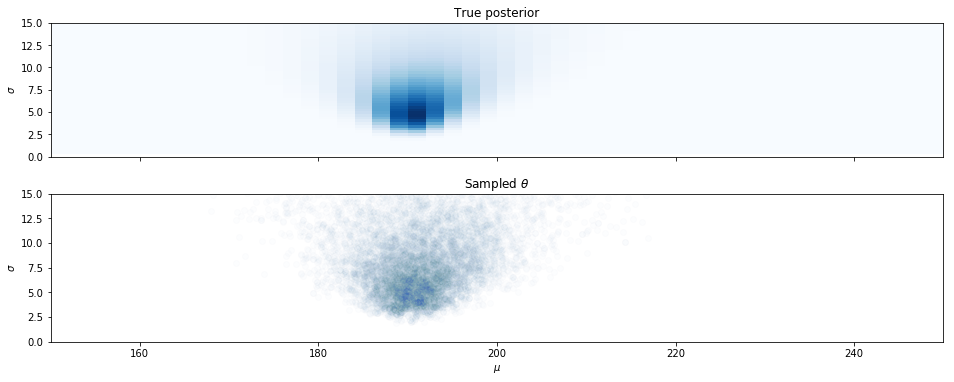

In [60]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(trace['mu'], trace['sigma'], alpha=0.01)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior')
axes[1].set_title('Sampled $\\theta$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())

In [4]:
import pyro
import pyro.distributions as dist
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
import torch
import torch.distributions.constraints as constraints

In [38]:

def model():
    # priors
    mu = pyro.sample('mu', dist.Normal(loc=torch.tensor(200.), 
                                       scale=torch.tensor(15.)))
    sigma = pyro.sample('sigma', dist.HalfCauchy(scale=torch.tensor(10.)))
    
    # likelihood
    with pyro.plate('plate', size=2):
        pyro.sample(f'obs', dist.Normal(loc=mu, scale=sigma), 
                    obs=torch.tensor([195., 185.]))
    
def guide():
    # variational parameters
    var_mu = pyro.param('var_mu', torch.tensor(180.))
    var_mu_sig = pyro.param('var_mu_sig', torch.tensor(5.), 
                             constraint=constraints.positive)
    var_sig = pyro.param('var_sig', torch.tensor(5.))
    
    # factorized distribution
    pyro.sample('mu', dist.Normal(loc=var_mu, scale=var_mu_sig))
    pyro.sample('sigma', dist.Chi2(var_sig))
    

In [53]:
pyro.clear_param_store()
pyro.enable_validation(True)

svi = SVI(model, guide, 
          optim=pyro.optim.ClippedAdam({"lr":0.01}), 
          loss=Trace_ELBO())

# do gradient steps
c = 0
for step in range(5000):
    c += 1
    loss = svi.step()
    if step % 100 == 0:
        print("[iteration {:>4}] loss: {:.4f}".format(c, loss))

[iteration    1] loss: 20.5714
[iteration  101] loss: 12.0774
[iteration  201] loss: 11.7402
[iteration  301] loss: 9.8967
[iteration  401] loss: 28.1990
[iteration  501] loss: 13.2090
[iteration  601] loss: 11.4618
[iteration  701] loss: 14.9521
[iteration  801] loss: 11.2410
[iteration  901] loss: 9.7651
[iteration 1001] loss: 9.7140
[iteration 1101] loss: 9.5427
[iteration 1201] loss: 9.0695
[iteration 1301] loss: 9.0411
[iteration 1401] loss: 10.2914
[iteration 1501] loss: 8.6590
[iteration 1601] loss: 9.7012
[iteration 1701] loss: 12.4810
[iteration 1801] loss: 8.0311
[iteration 1901] loss: 9.6596
[iteration 2001] loss: 10.1730
[iteration 2101] loss: 8.9640
[iteration 2201] loss: 9.5495
[iteration 2301] loss: 9.6852
[iteration 2401] loss: 10.8672
[iteration 2501] loss: 8.9980
[iteration 2601] loss: 8.3449
[iteration 2701] loss: 9.4454
[iteration 2801] loss: 9.4535
[iteration 2901] loss: 9.0612
[iteration 3001] loss: 8.6264
[iteration 3101] loss: 8.5423
[iteration 3201] loss: 7.183

In [54]:
print(pyro.param('var_mu').item(), pyro.param('var_mu_sig').item())
pyro.param('var_sig').item()

190.1922149658203 5.435718059539795


10.607619285583496

In [55]:
sigma = dist.Chi2(pyro.param('var_sig')).sample((10000,)).numpy()
mu = dist.Normal(pyro.param('var_mu'), pyro.param('var_mu_sig')).sample((10000,)).numpy()

(0, 15.0)

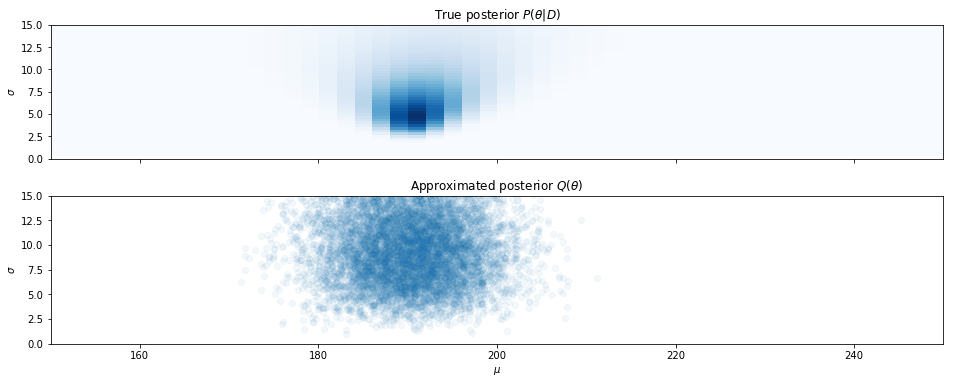

In [56]:
fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize = (16, 6))
axes[0].imshow(posterior, cmap='Blues', extent=extent, aspect=1)
axes[0].set_ylabel('$\sigma$')
axes[1].scatter(mu, sigma, alpha=0.05)
axes[1].set_ylabel('$\sigma$')
axes[0].set_title('True posterior $P(\\theta|D)$')
axes[1].set_title('Approximated posterior $Q(\\theta)$')
plt.xlabel('$\mu$')
plt.xlim(150, mm.max())
plt.ylim(0, ss.max())